<a href="https://colab.research.google.com/github/alexradecki/pokedex/blob/main/Pokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokedex
## Author: Alex Radecki
Using the data base scraped from the online Pokemon database (Source: https://pokemondb.net/pokedex/all), we will create an interactive Pokedex with working GUI after performing Exploratory Data Analysis on our data set.

## Import and Validation

In [131]:
# Importing required libraries
import requests, six
import lxml.html as lh
from itertools import cycle, islice
from matplotlib import colors
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
# Pokemon database from where we'll scrape our data
url = 'https://pokemondb.net/pokedex/all'

page = requests.get(url)
doc = lh.fromstring(page.content)

# Parse data between <tr> elements
tr_elements = doc.xpath('//tr')

In [133]:
# Creating headers that will store the subsequent values of each pokemon
col = []
i = 0

for t in tr_elements[0]:
  i += 1
  name = t.text_content()
  ## Validating headers were read as expected
  print('%d:"%s"' % (i, name))
  col.append((name, []))

1:"#"
2:"Name"
3:"Type"
4:"Total"
5:"HP"
6:"Attack"
7:"Defense"
8:"Sp. Atk"
9:"Sp. Def"
10:"Speed"


Populating attributes with corresponding column values:

In [134]:
for j in range(1, len(tr_elements)):
  T = tr_elements[j]

  # Ensures we only load rows from the Pokemon table, as they have 10 columns
  # (See block above for corresponding headers)
  if len(T) != 10:
    break

  # Instantiate column index
  i = 0

  # Iterating through each element of row
  for t in T.iterchildren():
    data = t.text_content()

    ## No decimal point values exist, converting data to integers for performance,
    ## leaving as string otherwise
    if i > 0:
      try:
        data = int(data)
      except:
        pass

    col[i][1].append(data)
    i += 1

In [159]:
Dict = {title:column for (title, column) in col}
df = pd.DataFrame(Dict)

In [160]:
# Verifying df was built as expected
df.head(10)

,#,Name,Type,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,\n\n\n0001,Bulbasaur,Grass Poison,318,45,49,49,65,65,45
1,\n\n\n0002,Ivysaur,Grass Poison,405,60,62,63,80,80,60
2,\n\n\n0003,Venusaur,Grass Poison,525,80,82,83,100,100,80
3,\n\n\n0003,Venusaur Mega Venusaur,Grass Poison,625,80,100,123,122,120,80
4,\n\n\n0004,Charmander,Fire,309,39,52,43,60,50,65
5,\n\n\n0005,Charmeleon,Fire,405,58,64,58,80,65,80
6,\n\n\n0006,Charizard,Fire Flying,534,78,84,78,109,85,100
7,\n\n\n0006,Charizard Mega Charizard X,Fire Dragon,634,78,130,111,130,85,100
8,\n\n\n0006,Charizard Mega Charizard Y,Fire Flying,634,78,104,78,159,115,100
9,\n\n\n0007,Squirtle,Water,314,44,48,65,50,64,43


In [156]:
# Removing spaces from Type column, as monotypes have trailing spaces. This will
# save us problems later when performing analysis on types
def remove_spaces(word):
  list = [x for x in word]
  for char_ind in range(0, len(list)):
    if list[char_ind] == ' ':
      list[char_ind] = ''
  final_list = ''.join(list)

  return final_list

In [161]:
# Applying remove_spaces function on Types and renaming 'Total' to 'BST'
df['Type'] = df['Type'].apply(remove_spaces)
df = df.rename(columns={'Total': 'BST'})

## Cleaning Data
Reformatting Name and Type sections

Here we will create a function that will add parentheses to a Pokemon's alternate forms, if applicable

In [140]:
# Puts special form in parentheses, if applicable
def str_parentheses(word):
  list = [x for x in word]
  for char_ind in range(1, len(list)):
    if list[char_ind].isupper():
      list[char_ind] = '*' + list[char_ind]
  final_list = ''.join(list).split('*')
  length = len(final_list)
  if length > 1:
    final_list.insert(1, '(')
    final_list.append(')')

  return ''.join(final_list)

In [162]:
# Apply parentheses function to df and verify output is as expected
df['Name'] = df['Name'].apply(str_parentheses)
df.head(10)

,#,Name,Type,BST,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,\n\n\n0001,Bulbasaur,GrassPoison,318,45,49,49,65,65,45
1,\n\n\n0002,Ivysaur,GrassPoison,405,60,62,63,80,80,60
2,\n\n\n0003,Venusaur,GrassPoison,525,80,82,83,100,100,80
3,\n\n\n0003,Venusaur (Mega Venusaur),GrassPoison,625,80,100,123,122,120,80
4,\n\n\n0004,Charmander,Fire,309,39,52,43,60,50,65
5,\n\n\n0005,Charmeleon,Fire,405,58,64,58,80,65,80
6,\n\n\n0006,Charizard,FireFlying,534,78,84,78,109,85,100
7,\n\n\n0006,Charizard (Mega Charizard X),FireDragon,634,78,130,111,130,85,100
8,\n\n\n0006,Charizard (Mega Charizard Y),FireFlying,634,78,104,78,159,115,100
9,\n\n\n0007,Squirtle,Water,314,44,48,65,50,64,43


## Statistical Analysis

Let's look for the best and worst Pokemon for each stat and BST. We will first create functions to find max and min, a list of the stats we wish to find (If we want to change it in the future) and call our functions on our Pokemon data frame using our list.

In [145]:
def max_stats(df, col_list):
  message = ''
  for col in col_list:
    stat = df[col].max()
    index_max = df[col].idxmax()
    name = df.at[index_max, 'Name']
    message += name + "'s " + col + ' of ' + str(stat) + ' is the highest.' + '\n'
  return message

def min_stats(df, col_list):
  message = ''
  for col in col_list:
    stat = df[col].min()
    index_min = df[col].idxmin()
    name = df.at[index_min, 'Name']
    message += name + "'s " + col + ' of ' + str(stat) + ' is the lowest.' + '\n'
  return message

In [146]:
stats = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'BST']

print(max_stats(df, stats))
print(min_stats(df, stats))

Blissey's HP of 255 is the highest.
Mewtwo (Mega Mewtwo X)'s Attack of 190 is the highest.
Eternatus (Eternamax)'s Defense of 250 is the highest.
Mewtwo (Mega Mewtwo Y)'s Sp. Atk of 194 is the highest.
Eternatus (Eternamax)'s Sp. Def of 250 is the highest.
Regieleki's Speed of 200 is the highest.
Eternatus (Eternamax)'s BST of 1125 is the highest.

Shedinja's HP of 1 is the lowest.
Chansey's Attack of 5 is the lowest.
Chansey's Defense of 5 is the lowest.
Sandshrew (Alolan Sandshrew)'s Sp. Atk of 10 is the lowest.
Caterpie's Sp. Def of 20 is the lowest.
Shuckle's Speed of 5 is the lowest.
Wishiwashi (Solo Form)'s BST of 175 is the lowest.



We will now create a scatter plot to see if there is any correlation between the stats.

array([[<Axes: xlabel='HP', ylabel='HP'>,
        <Axes: xlabel='Attack', ylabel='HP'>,
        <Axes: xlabel='Defense', ylabel='HP'>,
        <Axes: xlabel='Sp. Atk', ylabel='HP'>,
        <Axes: xlabel='Sp. Def', ylabel='HP'>,
        <Axes: xlabel='Speed', ylabel='HP'>],
       [<Axes: xlabel='HP', ylabel='Attack'>,
        <Axes: xlabel='Attack', ylabel='Attack'>,
        <Axes: xlabel='Defense', ylabel='Attack'>,
        <Axes: xlabel='Sp. Atk', ylabel='Attack'>,
        <Axes: xlabel='Sp. Def', ylabel='Attack'>,
        <Axes: xlabel='Speed', ylabel='Attack'>],
       [<Axes: xlabel='HP', ylabel='Defense'>,
        <Axes: xlabel='Attack', ylabel='Defense'>,
        <Axes: xlabel='Defense', ylabel='Defense'>,
        <Axes: xlabel='Sp. Atk', ylabel='Defense'>,
        <Axes: xlabel='Sp. Def', ylabel='Defense'>,
        <Axes: xlabel='Speed', ylabel='Defense'>],
       [<Axes: xlabel='HP', ylabel='Sp. Atk'>,
        <Axes: xlabel='Attack', ylabel='Sp. Atk'>,
        <Axes: xlabel='

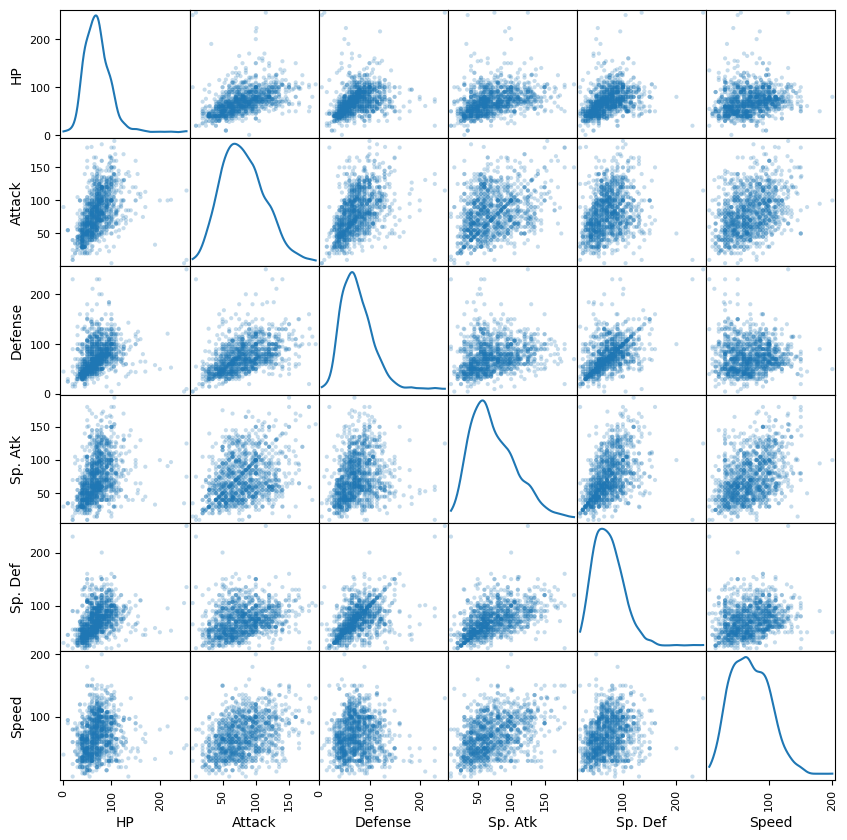

In [ ]:
from pandas.plotting import scatter_matrix
base_stats = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
scatter_matrix(df[base_stats], alpha = 0.25, figsize = (10, 10), diagonal = 'kde')

We can see that there is some correlation between Defense and Special Defense, Attack and Special Attack, and Special Attack and Special Defense.

Next, we will look at the average stats for each type. If a Pokemon has dual typing, its stats will count towards both types.

In [163]:
# Splits multi-type pokemon, 'Type' becomes column of lists
def str_break(word):
  list = [x for x in word]
  for char_ind in range(1, len(list)):
    if list[char_ind].isupper():
      list[char_ind] = '*' + list[char_ind]

  final_list = ''.join(list).split('*')

  return final_list

In [164]:
# Applying our function to the 'Type' column of our df
df['Type'] = df['Type'].apply(str_break)
df.head(10)

,#,Name,Type,BST,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,\n\n\n0001,Bulbasaur,"[Grass, Poison]",318,45,49,49,65,65,45
1,\n\n\n0002,Ivysaur,"[Grass, Poison]",405,60,62,63,80,80,60
2,\n\n\n0003,Venusaur,"[Grass, Poison]",525,80,82,83,100,100,80
3,\n\n\n0003,Venusaur (Mega Venusaur),"[Grass, Poison]",625,80,100,123,122,120,80
4,\n\n\n0004,Charmander,[Fire],309,39,52,43,60,50,65
5,\n\n\n0005,Charmeleon,[Fire],405,58,64,58,80,65,80
6,\n\n\n0006,Charizard,"[Fire, Flying]",534,78,84,78,109,85,100
7,\n\n\n0006,Charizard (Mega Charizard X),"[Fire, Dragon]",634,78,130,111,130,85,100
8,\n\n\n0006,Charizard (Mega Charizard Y),"[Fire, Flying]",634,78,104,78,159,115,100
9,\n\n\n0007,Squirtle,[Water],314,44,48,65,50,64,43


In [165]:
# Creating new df called types_df that has types separated and given separate row

new_dict = {}
# 'BST' is still referred to as 'Total' in Dict
stats_col = ['#', 'Name', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

Dict['Type'] = df['Type'].values

for col in stats_col:
  new_dict[col] = []
  new_dict['Type'] = []

for row in range(len(Dict['#'])):
  for t in Dict['Type'][row]:
    for col in stats_col:
      new_dict[col].append(Dict[col][row])
    new_dict['Type'].append(t)

types_df = pd.DataFrame(new_dict)
# Renaming 'Total' to 'BST'
types_df = types_df.rename(columns={'Total': 'BST'})

In [167]:
# Verifying method worked as expected. Each multi-type pokemon should have 2 rows
types_df.head(10)

,#,Type,Name,BST,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,\n\n\n0001,Grass,Bulbasaur,318,45,49,49,65,65,45
1,\n\n\n0001,Poison,Bulbasaur,318,45,49,49,65,65,45
2,\n\n\n0002,Grass,Ivysaur,405,60,62,63,80,80,60
3,\n\n\n0002,Poison,Ivysaur,405,60,62,63,80,80,60
4,\n\n\n0003,Grass,Venusaur,525,80,82,83,100,100,80
5,\n\n\n0003,Poison,Venusaur,525,80,82,83,100,100,80
6,\n\n\n0003,Grass,Venusaur Mega Venusaur,625,80,100,123,122,120,80
7,\n\n\n0003,Poison,Venusaur Mega Venusaur,625,80,100,123,122,120,80
8,\n\n\n0004,Fire,Charmander,309,39,52,43,60,50,65
9,\n\n\n0005,Fire,Charmeleon,405,58,64,58,80,65,80


Let's look at the mean, median, and standard deviation of Pokemon stats grouped by type

In [168]:
# Removing non-numeric columns from df
types_df = types_df.drop(['#', 'Name'], axis = 1)

types_df.groupby(['Type']).mean()

,BST,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Type,,,,,,,
Bug,380.790000,56.850000,71.030000,70.690000,55.950000,65.490000,60.780000
Dark,465.640449,75.101124,94.797753,71.876404,74.730337,70.898876,78.235955
Dragon,542.172043,88.677419,99.161290,88.344086,97.698925,86.064516,82.225806
Electric,450.724138,66.850575,75.517241,69.310345,86.195402,70.034483,82.816092
Fairy,448.081081,67.810811,70.027027,74.500000,80.743243,86.581081,68.418919
Fighting,486.315217,77.913043,108.793478,79.586957,65.945652,72.967391,81.108696
Fire,465.587629,71.329897,84.752577,71.432990,88.752577,73.329897,75.989691
Flying,456.280303,72.401515,81.553030,68.393939,77.310606,71.068182,85.553030
Ghost,454.770115,66.494253,79.402299,78.908046,83.747126,78.402299,67.816092


In [169]:
types_df.groupby(['Type']).median()

,BST,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Type,,,,,,,
Bug,395.0,60.0,65.0,60.0,50.0,60.0,55.0
Dark,485.0,70.0,92.0,70.0,69.0,65.0,75.0
Dragon,540.0,80.0,100.0,90.0,100.0,86.0,85.0
Electric,481.0,65.0,75.0,70.0,85.0,70.0,86.0
Fairy,478.5,65.0,65.0,72.5,80.0,84.5,62.0
Fighting,500.0,75.5,110.0,79.5,61.5,70.0,80.0
Fire,490.0,70.0,81.0,66.0,85.0,70.0,80.0
Flying,471.5,75.0,80.0,70.0,74.0,70.0,85.0
Ghost,480.0,60.0,75.0,75.0,80.0,75.0,69.0


In [170]:
types_df.groupby(['Type']).std()

,BST,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Type,,,,,,,
Bug,121.232917,17.827668,37.193041,32.376477,29.309348,30.664853,32.316484
Dark,111.792345,27.340881,29.737557,26.233575,30.259771,25.963280,25.620935
Dragon,143.362843,37.711479,30.286419,29.687318,37.760626,31.806414,29.089117
Electric,108.315183,22.685170,27.118972,25.355753,31.022437,21.321159,33.571350
Fairy,130.560305,22.930912,32.713774,29.626557,33.032181,31.376200,32.900017
Fighting,106.039380,22.169007,27.927118,24.424430,28.989336,22.905180,28.482675
Fire,110.303252,19.217354,29.818210,25.997559,31.985358,22.383365,25.940836
Flying,116.852639,20.527717,31.290638,23.814088,32.569393,25.772698,23.525953
Ghost,112.675981,27.796551,28.725023,30.803817,35.873881,26.933363,31.506931


We can see that Dragon appears to be the "best" typing, having the highest average stats for HP, Attack, Sp. Atk, and Sp. Def, the highest median stats for HP, Sp. Atk, Sp. Def, and Speed, and the highest average/median BST by a significant margin. This could be due to the fact that a large percentage of Legendaries (Powerful Pokemon, usually with a BST of at least 680) have Dragon typing (Almost 25%). Conversely, Bug appears to be the "weakest" type, having the lowest average/median BST, lowest average HP and Sp. Atk, and lowest median Defense, Sp. Atk, and Sp. Def. Bug is the typing most commonly found early on in the game, so it makes sense that they're the weakest type.

## GUI

Creating a Pokedex GUI

*Note: GUI not finished, need to debug. May try implementing simpler GUI in meantime*

In [ ]:
import pandas as pd
import sys, urllib3
import requests
from PyQt6 import QtNetwork
from PyQt6.QtGui import*
from PyQt6 import QtWidgets
from PyQt6.QtWidgets import*
from PyQt6 import QtCore
from PyQt6.QtCore import pyqtSignal, QTimer, QUrl

class Pokedex(QWidget):
  def __init__(self) -> None:
    super(Pokedex, self).__init__()
    self.initUI()

  def initUI(self):
    self.grid = QtWidgets.QGraphicsGridLayout
    self.setLayout(self.grid)

    self.df = pd.read_json('pokemonData.json')
    self.df = self.df.set_index(['#'])

    self.dropdown = QtWidgets.QFontComboBox(self)
    self.names = self.df['Name'].values
    self.dropdown.addItems(self.names)
    self.grid.addWidget(self.dropdown, 0,0,1,1)

    self.btn = QtWidgets.QPushButton('Search', self)
    self.btn.clicked.connect(self.runSearch)
    self.grid.addWidget(self.btn, 0,1,1,1)

    self.img = QtWidgets.QLabel(self)
    self.grid.addWidget(self.img, 1,1,1,1)

    self.label = QtWidgets.QLabel(self)
    self.label.setAlignment(QtCore.Qt.AlignCenter)
    self.label.setText('\nName:\n\nType:\n\nHP:\n\nAttack:\n\nSp. Attack:\n\nDefense:\n\nSp. Defense:\n\nSpeed:')
    self.label.setAlignment(QtCore.Qt.AlignLeft)
    self.grid.addWidget(self.label, 1,0,1,1)

    self.resize(500, 250)
    self.center()
    self.setWindowTitle('PokeDex')
    self.show()

  def runSearch(self):
    index = self.dropdown.currentIndex()
    val = self.names[index]
    cond = self.df['Name'] == val

    base = 'http://img.pokemondb.net/artwork/'
    img_url = base + val.lower() + '.jpg'
    data = urllib3.urlopen(img_url).read()
    image = QtGui.QImage()
    image.loadFromData(data)
    self.img.setPixmap(QtGui.setPixmap(image))

    name = 'Name:\t\t\t' + val + '\n\n'
    ty = 'Type:\t\t\t' + ', '.join(self.df[cond]['Type'].values[0]) + '\n\n'
    hp = 'HP:\t\t\t' + str(self.df[cond]['HP'].values[0]) + '\n\n'
    atk = 'Attack:\t\t\t' + str(self.df[cond]['Attack'].values[0]) + '\n\n'
    satk = 'Sp. Attack:\t\t\t' + str(self.df[cond]['Sp. Atk'].values[0]) + '\n\n'
    deff = 'Defense:\t\t\t' + str(self.df[cond]['Defense'].values[0]) + '\n\n'
    sdef = 'Sp. Defense:\t\t\t' + str(self.df[cond]['Sp. Def'].values[0]) + '\n\n'
    speed = 'Speed:\t\t\t' + str(self.df[cond]['Speed'].values[0]) + '\n\n'
    total = 'BST:\t\t\t' + str(self.df[cond]['BST'].values[0]) + '\n\n'

    final = name + ty + hp + atk + satk + deff + sdef + speed + total
    self.label.setText(final)

  def center(self):
    qr = self.frameGeometry()
    cp = QtWidgets.QDockWidget().availableGeometry().center()
    qr.moveCenter(cp)
    self.move(qr.topLeft())

def main():
  app = QtWidgets.QApplication(sys.argv)
  app.aboutToQuit.connect(app.deleteLater)

  gui = Pokedex()

  sys.exit(app.exec_())

if __name__ == '__main__':
  main()